# YoloV5 Custom Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/YOLOV5
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U -r yolov5/requirements.txt  # install dependencies

/content/drive/MyDrive/YOLOV5
Cloning into 'yolov5'...
remote: Enumerating objects: 6123, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 6123 (delta 82), reused 96 (delta 61), pack-reused 5980
Receiving objects: 100% (6123/6123), 8.72 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (4171/4171), done.
     |████████████████████████████████| 10.3MB 8.1MB/s 
     |████████████████████████████████| 15.3MB 207kB/s 
     |████████████████████████████████| 50.4MB 65kB/s 
     |████████████████████████████████| 3.0MB 53.7MB/s 
     |████████████████████████████████| 645kB 48.9MB/s 
     |████████████████████████████████| 27.4MB 116kB/s 
Requirement already up-to-date: torch>=1.7.0 in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 10)) (1.8.1+cu101)
Requirement already up-to-date: torchvision>=0.8.1 in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 11)) (0.9.1+cu10

In [3]:
#installing for google colab GPU use
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 26kB/s 
     |████████████████████████████████| 5.9MB 69.7MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [4]:
%cd /content/drive/MyDrive/YOLOV5/yolov5

/content/drive/MyDrive/YOLOV5/yolov5


In [5]:
import torch
from IPython.display import Image  # for displaying images
from utils.google_utils import gdrive_download  # for downloading models/datasets

## Dataset

In [22]:
%cat data.yaml

train: ../yolov5/train/images
val: ../yolov5/test/images

nc: 5
names: ['hat','vest','goggles','glove','shoe']



In [8]:
!unzip train.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/images/wh_dresscode_0835.jpg  
  inflating: train/images/wh_dresscode_2184.jpg  
  inflating: train/images/wh_dresscode_3811.jpg  
  inflating: train/images/wh_dresscode_0402.jpg  
  inflating: train/images/wh_dresscode_1087.jpg  
  inflating: train/images/wh_dresscode_0612.jpg  
  inflating: train/images/wh_dresscode_0873.jpg  
  inflating: train/images/wh_dresscode_0083.jpg  
  inflating: train/images/wh_dresscode_0746.jpg  
  inflating: train/images/wh_dresscode_1757.jpg  
  inflating: train/images/wh_dresscode_0679.jpg  
  inflating: train/images/wh_dresscode_1060.jpg  
  inflating: train/images/wh_dresscode_0332.jpg  
  inflating: train/images/wh_dresscode_2223.jpg  
  inflating: train/images/wh_dresscode_4905.jpg  
  inflating: train/images/wh_dresscode_3272.jpg  
  inflating: train/images/wh_dresscode_2640.jpg  
  inflating: train/images/wh_dresscode_3774.jpg  
  inflating: train/images/wh_dresscode_0285.jpg  

In [23]:
# define number of classes based on YAML
# data.yaml contains the information about number of classes and their labels required for this project
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [24]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [25]:
with open(r'data.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    labels_list = yaml.load(file, Loader=yaml.FullLoader)

    label_names = labels_list['names']

In [26]:
print("Number of Classes are {}, whose labels are {} for this Object Detection project".format(num_classes,label_names))

Number of Classes are 5, whose labels are ['hat', 'vest', 'goggles', 'glove', 'shoe'] for this Object Detection project


In [14]:
#this is the model configuration we will use for our tutorial 
# yolov5s.yaml contains the configuration of neural network required for training.
%cat /content/drive/MyDrive/YOLOV5/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [15]:
# Below we are changing the configuration so that it becomes compatible to number of classes required in this project
%%writetemplate /content/drive/MyDrive/YOLOV5/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes  # CHANGED HERE
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## Training

In [27]:
import os
os.chdir('/content/drive/MyDrive/YOLOV5/yolov5')

In [28]:
# train yolov5s on Aquarium object detection data for 100 epochs [aroung 1000 epochs for better training and result]
# NOTE: All the images are already pre-processed to 416 x 416 size.
# We will be training for 100 epoch (increase it for better result) with batch size of 80
# data.yaml also contains the information about location of Train and Validation Data. That's how you get the train data.
# the training also requires the configuration of neural network, which is in custom_yolov5s.yaml
# weights will be by-default stored at /content/yolov5/runs/exp2/weights/best.pt
# time its performance
%%time
%cd /content/drive/MyDrive/YOLOV5/yolov5/
!python train.py --img 416 --batch 80 --epochs 100 --data 'data.yaml' --cfg ./models/custom_yolov5s.yaml --weights ''

/content/drive/MyDrive/YOLOV5/yolov5
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-59-g31ee54c torch 1.8.1+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=80, bbox_interval=-1, bucket='', cache_images=False, cfg='./models/custom_yolov5s.yaml', data='data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp4', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=80, upload_dataset=False, weights='', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-05-02 15:31:33.644684: I tensorflow/stream_executor/platform/d

In [29]:
!pwd

/content/drive/My Drive/YOLOV5/yolov5


In [31]:
# use the best weights!
# Final weights will be by-default stored at /content/yolov5/runs/train/exp2/weights/best.pt
%cd /content/drive/MyDrive/YOLOV5/yolov5
#/content/drive/MyDrive/YOLOV5/yolov5
!python detect.py --weights /content/drive/MyDrive/YOLOV5/yolov5/runs/train/exp4/weights/best.pt --img 416 --conf 0.4 --source ./testing_images

/content/drive/My Drive/YOLOV5/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=416, iou_thres=0.45, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='./testing_images', update=False, view_img=False, weights=['/content/drive/MyDrive/YOLOV5/yolov5/runs/train/exp4/weights/best.pt'])
YOLOv5 🚀 v5.0-59-g31ee54c torch 1.8.1+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7257306 parameters, 0 gradients, 16.8 GFLOPS
image 1/7 /content/drive/MyDrive/YOLOV5/yolov5/testing_images/wh_dresscode_0001.jpg: 320x416 1 hat, Done. (0.011s)
image 2/7 /content/drive/MyDrive/YOLOV5/yolov5/testing_images/wh_dresscode_0002.jpg: 320x416 2 vests, Done. (0.008s)
image 3/7 /content/drive/MyDrive/YOLOV5/yolov5/testing_images/wh_dresscode_0003.jpg: 320x416 1 hat, Done. (0.008s)
image 4/7 /content/drive/M

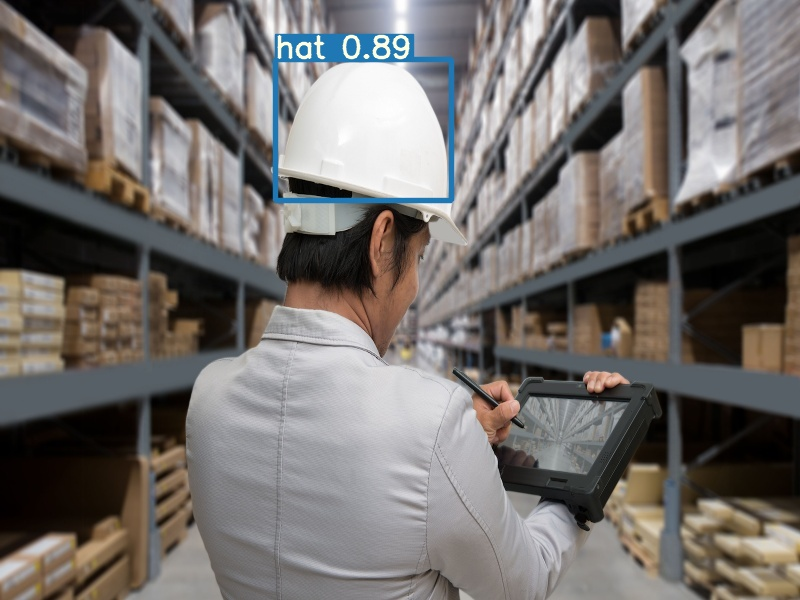

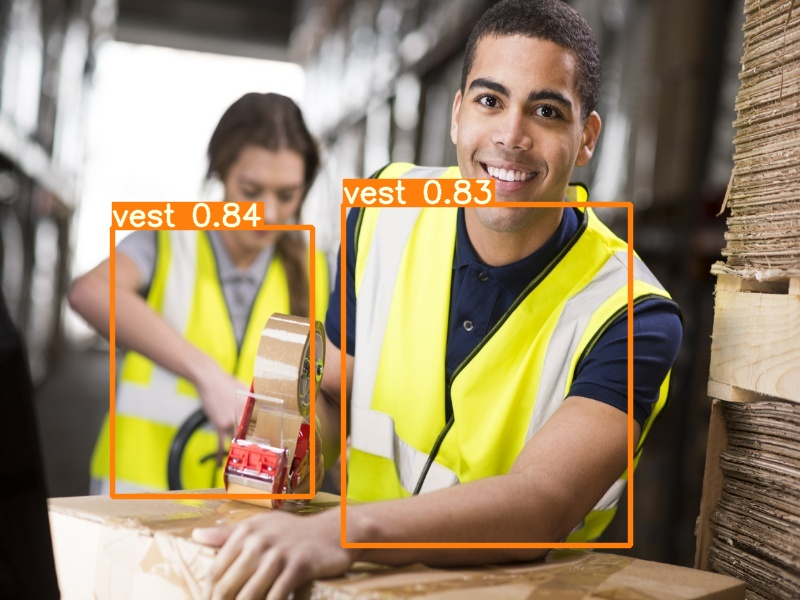

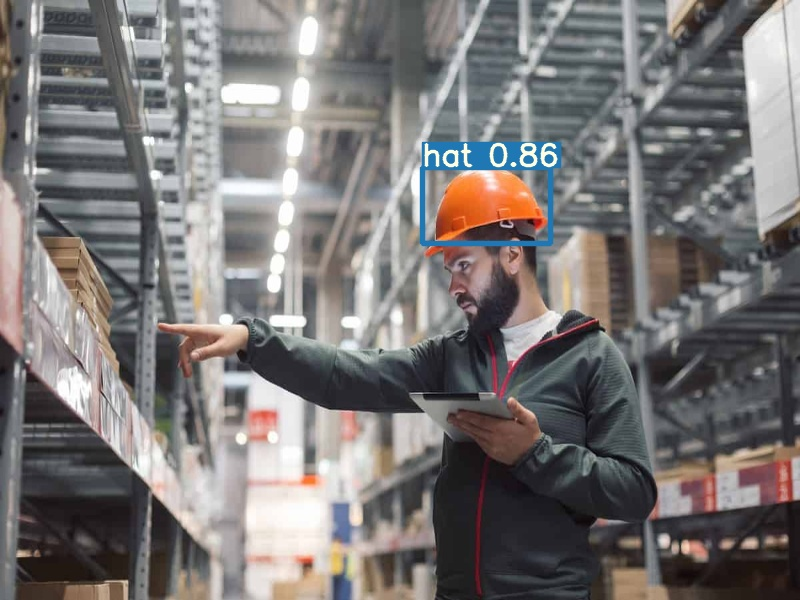

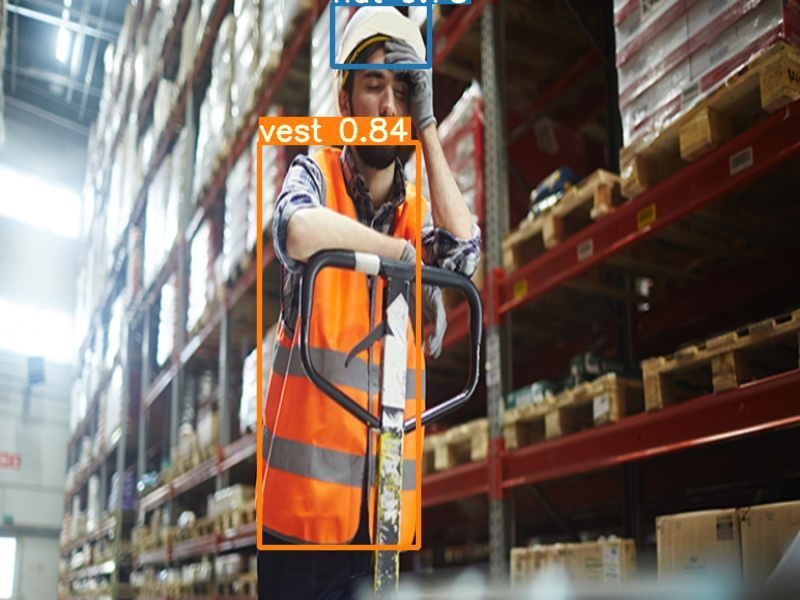

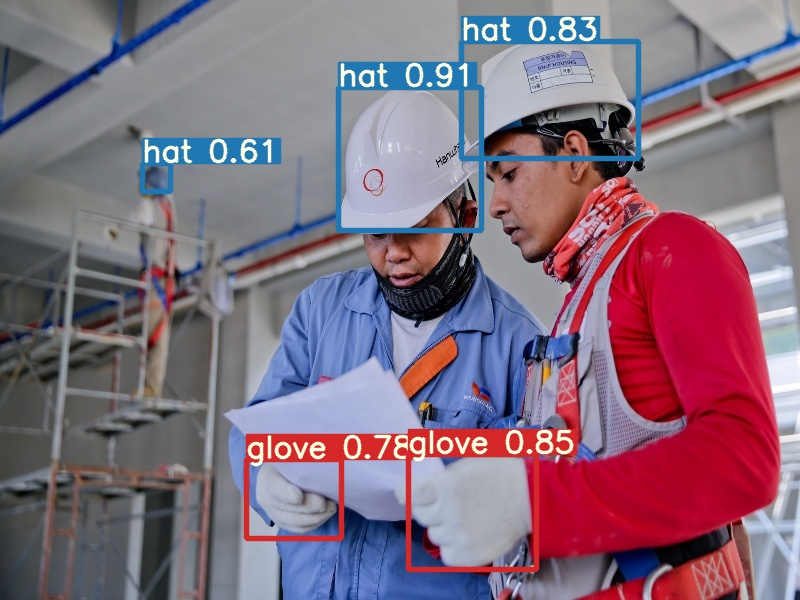

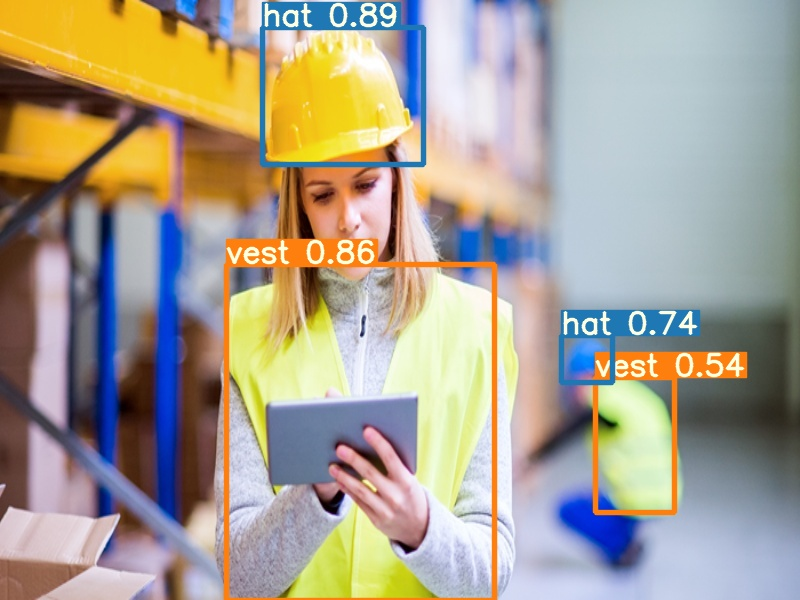

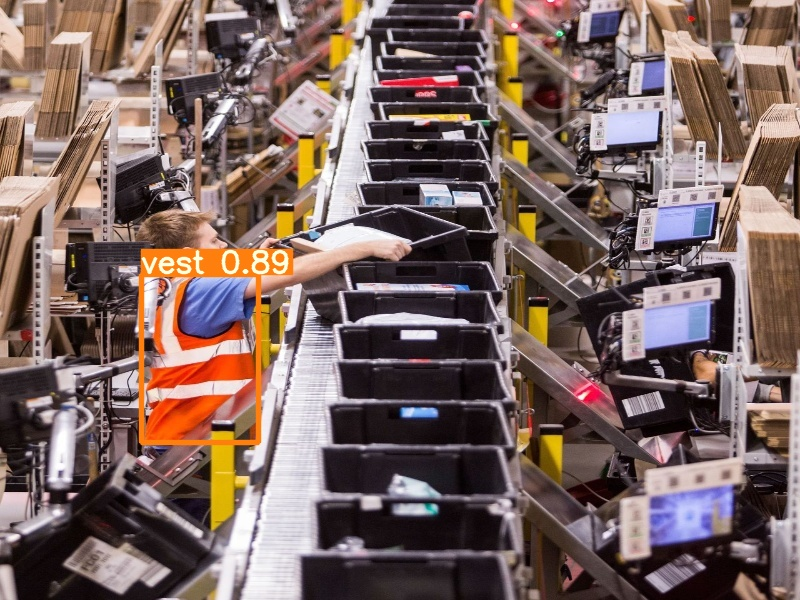

In [33]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/drive/MyDrive/YOLOV5/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

### The trained weight for this model is in runs/train/exp4/weights/best.pt